# Проект: Определение возраста покупателей

## Описание проекта

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

* Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
* Контролировать добросовестность кассиров при продаже алкоголя.

Нам необходимо построить модель, которая по фотографии определит приблизительный возраст человека. В нашем распоряжении есть набор фотографий людей с указанием возраста.

### Описание данных

Данные находятся в папке `/datasets/faces/`, которая содержит в себе одну папку со всеми изображениями (`/final_files`) и CSV-файл `labels.csv` с двумя колонками: `file_name` и `real_age`.

### Этапы проекта

* Первым делом мы загрузим данные и изучим их. Проведём исследовательский анализ набора фотографий;
* Подготовим данные к обучению;
* Обучим модель и рассчитаем её качество;
* Проведём анализ эксперимента и сделаем выводы.

### Разбор задачи

* Так как нам нужно по фотографии определить возраст человека, а это некоторое дискретное число, то перед нами стоит задача регрессии;
* Возможными функциями потерь для регрессии могут быть Mean *Squared Error* и *Mean Absolute Error*;
* При использовании нейронной сети для задачи регресси нужен один нейрон, который вернёт число-предсказание;
* Для последнего нейрона необходимо выбрать активацию *ReLu*, так как возраст не может быть меньше нуля. Эта функция не меняет положительные прогнозы, а все отрицательные приводит к нулю.

### Предварительные настройки

Загрузим необходимые пакеты/библиотеки для предстоящей работы.

In [1]:
# загружаем библиотеку для работы с табличными данными
import pandas as pd
# загружаем бибилиотеку для работы с графиками 
import matplotlib.pyplot as plt
# загружаем библиотеку для генерации данных изображения
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Исследовательский анализ данных

Загрузим наши данные и изучим их общую информацию. В качестве исследования мы сделаем следующее:

* посмотрим на размер предоставленной выборки;
* построим гистограмму распределения возраста в выборке;
* изучим 10-15 фотографий и посмотрим, как устроен датасет.

In [2]:
# загружаем табличные данные
labels = pd.read_csv('/datasets/faces/labels.csv')

In [3]:
# выводим датафрейм на экран
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


Таблица имеет два столбца, как и было заявлено. В первом столбце `file_name` содержится имя файла в формате jpg. Это фотография наблюдаемого человека. Во втором столбце `real_age` указан возраст человека, изображённого на наблюдаемой фотографии. Данный признак является целевым.

In [4]:
# получаем общую информацию 
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


Всего наблюдается $7591$ человек, пропусков в таблице не обнаружено. Возраст представлен в целочисленном виде, то есть мы имеем дело с возрастом полных лет — в этом случае возраст человека округляется в меньшую сторону.

In [5]:
# проверяем наличие дубликатов
labels.duplicated().sum()

0

В загруженном датафрейме дубликатов не найдено. Теперь изучим описательные статистики данных и распределение возраста в выборке.

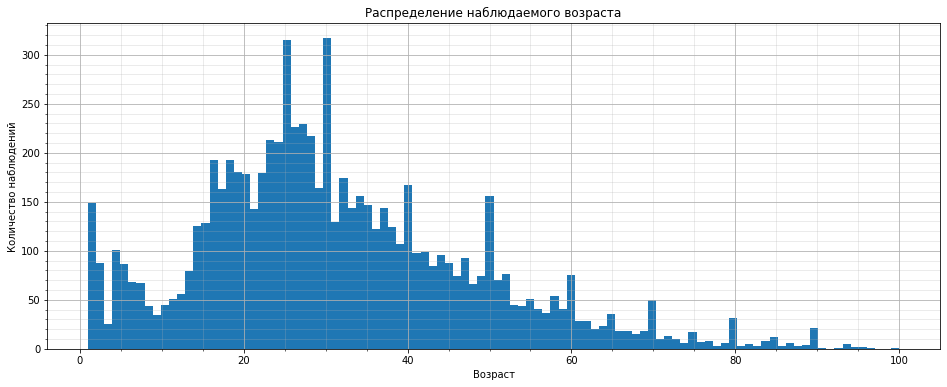

In [6]:
# строим гистограмму распределения возраста
labels.hist(bins=100, figsize=(16, 6))
# настраиваем график
plt.title('Распределение наблюдаемого возраста')
plt.xlabel('Возраст')
plt.ylabel('Количество наблюдений')
plt.minorticks_on()
plt.grid(which='minor', alpha=.3)

In [7]:
# вывобим статистики
labels.describe().T

,count,mean,std,min,25%,50%,75%,max
real_age,7591.0,31.201159,17.14506,1.0,20.0,29.0,41.0,100.0


Распределение имеет скошеноность в сторону молодого возраста. Об этом свидетельствует мдиана — 29 лет. Наблюдаются пики по всему распределению, которые приходятся на «юбилейные» годы — 30, 40, 50, 60 и так далее. Это может быть связано с тем, что при разметке данных возраст наблюдаемого человека не был достоверно известен, и его попросту округлили.

Заметное количество наблюдений приходится на возраст до 10 лет. Наблюдается небольшая бимодальность. Возможно, данная выборка была составлена не случайным образом. Изучим распределние по возрастным группам, чтобы понять насколько она неоднородна. Разделение произведём согласно [приведённой категоризации](https://www.myagecalculator.com/blog/life-stages-and-age-groups-40).

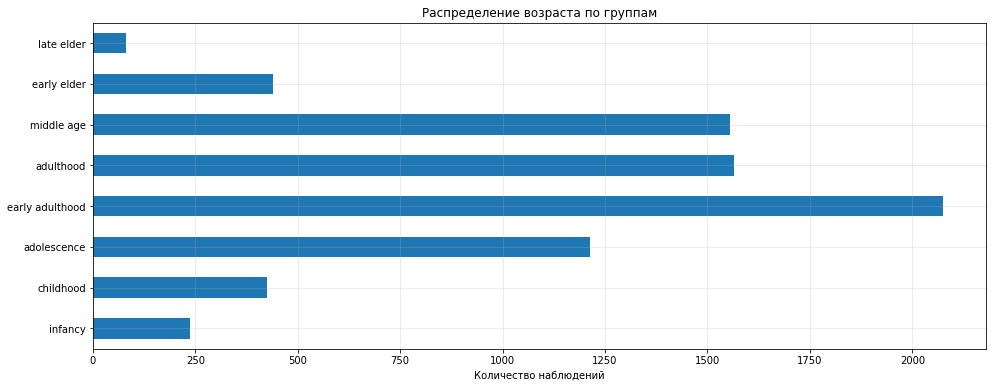

In [8]:
# бинаризируем данные
labels['category_age'] = pd.cut(labels['real_age'], 
                                bins=[0, 2, 9, 19, 29, 39, 59, 80, 100], 
                                labels=['infancy', 'childhood', 'adolescence', 
                                        'early adulthood', 'adulthood', 'middle age', 
                                        'early elder', 'late elder'])
# строим гистограмму распределения возраста по группам
labels['category_age'].value_counts() \
                      .sort_index() \
                      .plot(kind='barh', figsize=(16, 6))
# настраиваем график
plt.title('Распределение возраста по группам')
plt.xlabel('Количество наблюдений')
plt.grid(alpha=.3)

Основную часть данных представляет возраст от 10 до 60, включающий такие группы как:

* подростковый возраст, от 10 до 19;
* ранняя зрелость, от 20 до 29;
* зрелость, от 30 до 39;
* средний возраст, от 40 до 59.

Младенчество и детство, как и пожилой возраст (ранний и поздний) представленны в меньшем количестве, что может быть недостаточным для обучения. Как результат мы можем ожидать ошибки определения возраста именно в этих группах.

Изучим сами фотографии. Извлечём изображения из папки и выведем на экран 10-15 фотографий.

In [9]:
# инициируем генератор данных для изображений
datagen = ImageDataGenerator(rescale=1./255)
# извлекаем данные из папки с изображениями
datagen_flow = datagen.flow_from_dataframe(dataframe=labels, 
                                           directory='/datasets/faces/final_files/',
                                           x_col='file_name',
                                           y_col='real_age',
                                           target_size=(224, 224),
                                           batch_size=32,
                                           class_mode='raw',
                                           seed=42)

Found 7591 validated image filenames.


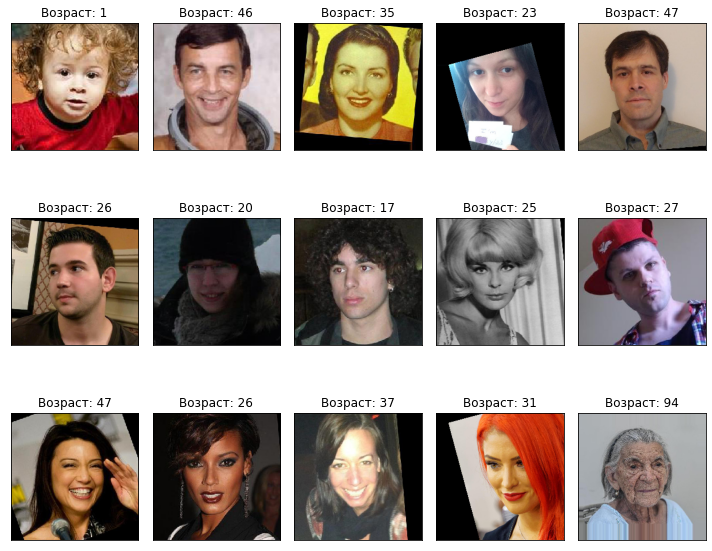

In [10]:
# получаем фотографии и возраст людей из батча 
images, ages = next(datagen_flow)
# создаём общую фигуру для графиков
fig = plt.figure(figsize=(10, 10))
# циклом выводим фотографии и возраст
for i in range(15):
    # добавляем фигуру     
    fig.add_subplot(3, 5, i+1)
    # выводим изображение человека
    plt.imshow(images[i])
    # выводим возраст человека
    plt.title(f'Возраст: {ages[i]}')
    # настраиваем график
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

На фотографиях изображены портреты людей разной возрастной категории, качество изображений различается. Фотографии имеют квадратную форму, ориентация примерно одинаковая. Черные рамки на некоторых фотографиях свидетельствуют о том, что изначально изображения были разного размера, но в конечном итоге приведены к одной форме и ориентации.

### Вывод исследования

* В ходе исследования мы выяснили, что представленные данные имеют некоторую неоднородность в возрастных группах. Подавляющую часть данных представляют подростки и взрослые вплодь до среднего возраста. В недостаточном объёме представлены пожилые люди и дети. Это может повлиять на качество предсказания возраста людей именно в этих группах. В дальнейшем неплохо было бы добавить в выборку эти возрасты для выравнивания однородности.
* Пики «юбилейных» лет, возникшие при разметке данных, вносят некоторую погрешность в истинность данных, что может немного смазать результат предсказания;
* Фотографии имеют примерно одинаковую ориентацию — некоторые фото уже повернули за нас, чтобы выровнять положение лица. Это значит, что нам не придётся их поворачивать перед обучением.
* Начальный размер фотографий отличается — визуально заметно различное качество фото, где-то есть черные рамки, которые не несут полезной инофрмации.

## Обучение модели

Нашей задачей является построение и обучение свёрточной сети на датасете с фотографиями людей. Качество модели мы будем оценивать метрикой *MAE*, которая вычисляется по следующей формуле:

$$
MAE = \frac{1}{N} \sum^N_{i=1} |y_i - \hat{y}|
$$

где $y_i$ — фактическое значение; $\hat{y}$ — предсказанное значение; $N$ — число наблюдений в выборке.

Таким образом, *средняя абсолютная ошибка* это среднее абсолютных разностей между наблюдаемым и предсказанным возрастами. Значение *MAE* на тестовой выборке не должно быть больше 8. Это наш бейзлайн.

За основу модели мы возьмём предобученную нейронную сеть ResNet50 с отсечённой верхушкой, так как эта сеть обучалась классифицировать изображения на 1000 классов. Перед нами же стоит задача регрессии, а значит, на выходе нам нужен всего один нейрон, который вернёт число-предсказание. Поэтому мы добавим к основе свою верхушку: слой с глобальным усреднением окна пикселей и полносвязный слой с одним нейроном и функцией активации *ReLu*. В качестве алгоритма обучения мы выберем *Adam* с фиксированным шагом обучения.

Обучение такой нейронной сети на 7591 образце потребует больших вычислительных мощностей, если мы хотим достаточно быстро увидеть результат обучения. Поэтому мы будем использовать удалённый GPU сервер. Для того, чтобы сервер смог реализовать нашу задачу, мы должны написать четыре функции, которые будут вызваны последовательно.

Первая функция `load_train` подготовит данные к обучению. На вход она будет принимать путь к данным. В теле функции данные буду сгенерированы в тензоры, нормированы и разделены в соотношении 75/25 для валидациии. Полученные тензоры будут сформированы в батчи по 32. Размер изображения будет приведён к единому — 224 на 224 пикселя. Именно  такой размер был у изображений в датасете ImageNet, на котором обучалась ResNet50. Функция вернёт объект, содержащий батчи с готовыми тензорами для обучения.

Вторая функция `load_test` подготовит данные для тестирования модели. Процесс обработки аналогичен первой функции. Функция вернёт объект, содержащий батчи с готовыми тензорами для тестирования.

Третья функция `create_model` создаст модель с заданной архитектурой, которую мы описали выше. На вход она будет принимать размер данных. Функция вернёт готовую к обучению модель.

Четвёртая функция `train_model` обучит созданную модель на подготовленных данных. На вход она будет принимать модель, обучающую выборку, тестовую выборку, размер батчей, количество эпох обучения и другие параметры. В теле функция обучит модель с заданными параметрами, проведёт валидацию. В качестве функции потерь мы выберем *MSE*, потому что зачастую нейронные сети с этой функцией потерь обучаются быстрее. После обучения и валидации функция `train_model` вернёт обученную модель.

Код всех функций и вывод метрик приводится ниже.

```python

import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam

# объявляем функцию генерации обучающих данных
def load_train(path):
    # загружаем метки
    labels = pd.read_csv(path + 'labels.csv')
    # инициируем генератор данных изображения
    train_datagen = ImageDataGenerator(rescale=1. / 255,
                                       validation_split=.25)
    # генерируем данные изображения
    train_datagen_flow = train_datagen.flow_from_dataframe(dataframe=labels,
                                                           directory=path + 'final_files/',
                                                           x_col='file_name',
                                                           y_col='real_age',
                                                           target_size=(224, 224),
                                                           batch_size=32,
                                                           class_mode='raw',
                                                           subset='training',
                                                           seed=42)
    # возвращаем результат
    return train_datagen_flow

# объявляем функцию генерации тестовых данных
def load_test(path):
    # загружаем метки
    labels = pd.read_csv(path + 'labels.csv')
    # инициируем генератор данных изображения
    test_datagen = ImageDataGenerator(rescale=1. / 255, validation_split=.25)
    # генерируем данные изображения
    test_datagen_flow = test_datagen.flow_from_dataframe(dataframe=labels,
                                                         directory=path + 'final_files/',
                                                         x_col='file_name',
                                                         y_col='real_age',
                                                         target_size=(224, 224),
                                                         batch_size=32,
                                                         class_mode='raw',
                                                         subset='validation',
                                                         seed=42)
    # возвращаем результат
    return test_datagen_flow


# объявляем функцию создания модели
def create_model(input_shape):
    # инициируем нейронную сеть
    backbone = ResNet50(input_shape=input_shape,
                        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                        include_top=False)
    # инициируем модель
    model = Sequential()
    # добавляем resnet50
    model.add(backbone)
    # добавляем усреднение группы пикселей
    model.add(GlobalAveragePooling2D())
    # добавляем слой регрессии
    model.add(Dense(1, activation='relu'))
    # настраиваем обучение модели
    model.compile(optimizer=Adam(lr=0.0001),
                  loss='mean_squared_error',
                  metrics=['mae'])
    # возвращаем модель
    return model

#  объявлляем функцию обучения модели
def train_model(model, train_data, test_data,
                batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):
    # обучаем модель
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)
    # возвращаем обученную модель
    return model
```

```

Train for 178 steps, validate for 60 steps
Epoch 1/20
178/178 - 52s - loss: 224.3213 - mae: 10.7926 - val_loss: 1021.6416 - val_mae: 27.1746
Epoch 2/20
178/178 - 43s - loss: 59.4098 - mae: 5.8283 - val_loss: 965.6090 - val_mae: 26.2246
Epoch 3/20
178/178 - 42s - loss: 31.8215 - mae: 4.3352 - val_loss: 348.1416 - val_mae: 13.8115
Epoch 4/20
178/178 - 43s - loss: 21.1009 - mae: 3.5258 - val_loss: 155.7642 - val_mae: 9.4592
Epoch 5/20
178/178 - 43s - loss: 15.8657 - mae: 3.0914 - val_loss: 80.8530 - val_mae: 6.8933
Epoch 6/20
178/178 - 43s - loss: 12.6683 - mae: 2.7470 - val_loss: 94.9508 - val_mae: 7.7646
Epoch 7/20
178/178 - 42s - loss: 10.9198 - mae: 2.5180 - val_loss: 71.6926 - val_mae: 6.4623
Epoch 8/20
178/178 - 42s - loss: 9.2455 - mae: 2.2895 - val_loss: 77.6112 - val_mae: 6.5492
Epoch 9/20
178/178 - 43s - loss: 8.9571 - mae: 2.2387 - val_loss: 68.4419 - val_mae: 6.2601
Epoch 10/20
178/178 - 43s - loss: 7.9782 - mae: 2.1271 - val_loss: 69.0425 - val_mae: 6.2397
Epoch 11/20
178/178 - 43s - loss: 7.4745 - mae: 2.0666 - val_loss: 68.7557 - val_mae: 6.1955
Epoch 12/20
178/178 - 43s - loss: 6.7961 - mae: 1.9776 - val_loss: 67.4518 - val_mae: 6.2468
Epoch 13/20
178/178 - 43s - loss: 6.1050 - mae: 1.8756 - val_loss: 66.7448 - val_mae: 6.1805
Epoch 14/20
178/178 - 42s - loss: 5.8241 - mae: 1.8290 - val_loss: 69.3590 - val_mae: 6.3991
Epoch 15/20
178/178 - 43s - loss: 4.9868 - mae: 1.6860 - val_loss: 66.6125 - val_mae: 6.3257
Epoch 16/20
178/178 - 43s - loss: 4.8045 - mae: 1.6433 - val_loss: 68.0795 - val_mae: 6.1381
Epoch 17/20
178/178 - 43s - loss: 5.2012 - mae: 1.7105 - val_loss: 72.9706 - val_mae: 6.5268
Epoch 18/20
178/178 - 43s - loss: 5.5948 - mae: 1.7690 - val_loss: 69.6351 - val_mae: 6.4561
Epoch 19/20
178/178 - 44s - loss: 5.9640 - mae: 1.8518 - val_loss: 66.4244 - val_mae: 6.2080
Epoch 20/20
178/178 - 43s - loss: 5.8783 - mae: 1.8202 - val_loss: 64.0365 - val_mae: 6.0656

60/60 - 10s - loss: 64.0365 - mae: 6.0656
Test MAE: 6.0656
```

## Анализ обученной модели

В результате [экспериментов](https://gorodokin.notion.site/23fab07b1f73488e929c5654b03abf20?pvs=4) c гиперпараметрами нейронной сети нам удалось получить метрику ниже установленного бейзлайна — наша *MAE* ниже 8, и на тестовой выборке составляет 6.1. Гиперпараметры нейронной сети были следующими:

* данные загружались батчами по 32 тензора;
* при загрузке данные нормировались до диапазона 0-1;
* изображения приводились к размеру 224 на 224 пикселя;
* аугментация изображений не проводилась, так как при проведении экспериментов это ухудшало метрику;
* при создании предобученной ResNet50 использовались началные готовые веса, загруженные на сервер;
* шаг обучения был выбран 0.0001. Большой шаг мог бы уменьшить скорость обучения, но при этом увеличится бы риск попадания в локальный минимум функции потерь;
* при обучении проводилось 20 эпох.

Обучение двадцати эпох длилось 866 секунд или 14.5 минут. Среднее время обучение одной эпохи 43 секунды. Анализируя метрику на валидации по всем эпохам можно сделать вывод, что обучение происходило довольно стабильно: первые девять эпох потери заметно уменьшались, далее стабилизировались в районе 70. Если сравнить метрики на обучающей и валидационной выборке на 20 эпохах переобучения пока не наблюдалось. 

## Общий вывод

Целью данного проекта было построение модели, которая по изображению сможет определить приблизительный возраст человека. В нашем распоряжении — набор фотографий людей с указанием их возраста. Нам необходимо было построить и обучить свёрточную нейронную сеть на этом датасете и добиться значения *MAE* на тестововй выборке не больше 8.

Сперва мы провели исследовательский анализ данных: изучили CSV-файл и несколько фотографий из папки со всеми изображениями. Загруженная таблица из файла имеет два столбца. В первом угазано имя файла изображения, во втором — возраст человека, изображённого на этой фотографии. Всего наблюдается 7591 человек. Пропусков в таблице нет, дубоикатов не обнаружено.

Распределение имеет скошенность в сторону молодого возраста, медиана выборки — 29 лет. Есть небольшая бимодальность. Наблюдаются пики значений, которые приходятся на «юбилейные» года.

При разделении выборки на группы обнаружена неоднородность. Основную часть данных представляет возраст от 10 до 60, включающий такие группы как:

* подростковый возраст, от 10 до 19;
* ранняя зрелость, от 20 до 29;
* зрелость, от 30 до 39;
* средний возраст, от 40 до 59.

Младенчество и детство, как и пожилой возраст (ранний и поздний) представленны в малом количестве.

Описанные выше наблюдения указывают нам на некоторые вероятные моменты:

* данная выборка была составлена не случайным образом (неоднородность групп, бимодальность);
* при разметке данных в некоторых наблюдениях возраст человека не был достоверно известен, поэтому его примерно округлили (пиковые значения «юбилейных» годов).

Данные моменты могут повлиять на качество предсказания возраста людей в недлостающих группах, а сам результат предсказания может быть немного смазанным из-за погрешностей. В дальнейшем рекомендуется обратить внимание на эти моменты при формировании выборки.

Далее мы извлекли несколько фотографий из предоставленной папки с изображениями.

На фотографиях изображены портреты людей разной возрастной категории, качество изображений различается. Фотографии имеют квадратную форму, ориентация примерно одинаковая. Черные рамки на некоторых фотографиях свидетельствуют о том, что изначально изображения были разного размера, но в конечном итоге приведены к одной форме и ориентации. Целевой размер при загрузке мы указали 224 на 224 пикселя, так как такой размер изображений использовался в датасете *ImageNet* при обучении нейронной сети, которую мы использовали для решения поставленной задачи.

За основу модели мы взяли предобученную нейронную сеть *ResNet50* с отсечённой верхушкой. В качестве регрессора использовали полносвязный слой с функцией активации *ReLu*, перед которым было произведено глобальное усреднение пикселей. На вход мы подавали данные, сгенерированные батчами размером 32. При обучении мы использовали алгоритм *Adam* c шагом обучения 0.001, функцию потерь *MSE*. Качество модели мы оценивали метрикой *MAE*. Обучение происходило в течение двадцати эпох. Время обучения заняло 866 секунд или 14.5 минут.

С каждой эпохой наша модель всё лучше определяла возраст, где метрика достигла своего минимума на последней эпохе — *MAE:* 6.1. Тестирование показало, что модель справляется с поставленной задачей, качество модели лучше установленного бейзлайна *MAE:* 8. Тестирование заняло 10 секунды.

Цели проекта были достигнуты, а поставленная задача выполнена. В качестве рекомендаций по улучшению качества можно отметить следующее:

* при формировании выборки для обучения следует учесть однородность возрастных групп;
* возможно, в текущую архитектуру следует добавить несколько полносвязных слоёв перед регрессором;
* следует увеличить количество эпох и использовать раннюю остановку для предотвращения ухудшения метрик.